In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import cv2

In [424]:
c = 1.0
mu_0 = 1.0
epsilon0 = 1.0 / (mu_0 * c**2)
m_electron = 1.0
r_m = 1 / 25
m_ion = m_electron / r_m
t_r = 1.0
ne0_pic = 100 #ここは手動で調整すること
ni0_pic = ne0_pic
B0_pic = np.sqrt(ne0_pic) / 1.0
Te_pic = 0.5 * m_electron * (0.3*c)**2
Ti_pic = Te_pic / t_r
q_electron = -1 * np.sqrt(epsilon0 * Te_pic / ne0_pic)
q_ion = -1 * q_electron
debye_length = np.sqrt(epsilon0 * Te_pic / ne0_pic / q_electron**2)
omega_pe = np.sqrt(ne0_pic * q_electron**2 / m_electron / epsilon0)
omega_pi = np.sqrt(ni0_pic * q_ion**2 / m_ion / epsilon0)
omega_ce = q_electron * B0_pic / m_electron
omega_ci = q_ion * B0_pic / m_ion
VA_pic = B0_pic / np.sqrt(mu_0 * ni0_pic * m_ion)
gamma_pic = 5.0 / 3.0
rho_pic = ni0_pic * m_ion + ne0_pic * m_electron
p_pic = ni0_pic * Ti_pic + ne0_pic * Te_pic
CS_pic = np.sqrt(gamma_pic * p_pic / rho_pic)
v_thermal_electron = np.sqrt(2.0 * Te_pic / m_electron)
v_thermal_ion = np.sqrt(2.0 * Ti_pic / m_ion)
ion_inertial_length = c / omega_pi

dx_pic = 1.0
nx_pic = 20
x_min_pic = 1e-10
x_max_pic = nx_pic * dx_pic - 1e-10
x_coordinate_pic = np.arange(0.0, x_max_pic, dx_pic)
dy_pic = 1.0
ny_pic = 1000
y_min_pic = 1e-10
y_max_pic = ny_pic * dy_pic - 1e-10
y_coordinate_pic = np.arange(0.0, y_max_pic, dy_pic)

X_pic, Y_pic = np.meshgrid(x_coordinate_pic, y_coordinate_pic)

n_ion = int(ni0_pic * nx_pic)
n_electron = int(n_ion * abs(q_ion / q_electron))

In [425]:
gamma_mhd = 5.0 / 3.0
B0_mhd = B0_pic
rho0_mhd = ne0_pic * m_electron + ni0_pic * m_ion
p0_mhd = ne0_pic * Te_pic + ni0_pic * Ti_pic
VA_mhd = B0_mhd / np.sqrt(rho0_mhd)
CS_mhd = np.sqrt(gamma_mhd * p0_mhd / rho0_mhd)
Cf_mhd = np.sqrt(VA_mhd**2 + CS_mhd**2)
beta_mhd = p0_mhd / (B0_mhd**2 / 2)

dx_mhd = dx_pic
nx_mhd = nx_pic
x_min_mhd = 1e-10
x_max_mhd = nx_mhd * dx_mhd - 1e-10
dy_mhd = dy_pic
ny_mhd = 9550
y_min_mhd = 1e-10
y_max_mhd = ny_mhd * dy_mhd - 1e-10

x_coordinate_mhd = np.arange(x_min_mhd, x_max_mhd, dx_mhd)
y_coordinate_mhd = np.arange(y_min_mhd, y_max_mhd, dy_mhd)
X_mhd, Y_mhd = np.meshgrid(x_coordinate_mhd, y_coordinate_mhd)

In [426]:
window_size_convolution_pic = 10
window_size_smoothing_mhd = 5
interface_width = 50

index_interface_mhd_start_left = nx_mhd - interface_width
index_interface_mhd_end_left = nx_mhd
index_interface_mhd_start_right = 0
index_interface_mhd_end_right = interface_width
index_interface_pic_start_left = 0
index_interface_pic_end_left = interface_width
index_interface_pic_start_right = nx_pic - interface_width
index_interface_pic_end_right = nx_pic

プロット

In [596]:
dirname = "results_alfven"
step = 9000
filename = f"{dirname}/alfven_B_{step}.bin"
with open(filename, 'rb') as f:
    B = np.fromfile(f, dtype=np.float64)
B = B.reshape(nx_pic, ny_pic, 3).T
filename = f"{dirname}/alfven_E_{step}.bin"
with open(filename, 'rb') as f:
    E = np.fromfile(f, dtype=np.float64)
E = E.reshape(nx_pic, ny_pic, 3).T
filename = f"{dirname}/alfven_current_{step}.bin"
with open(filename, 'rb') as f:
    current = np.fromfile(f, dtype=np.float64)
current = current.reshape(nx_pic, ny_pic, 3).T

filename = f"{dirname}/alfven_zeroth_moment_ion_{step}.bin"
with open(filename, 'rb') as f:
    zeroth_moment_ion = np.fromfile(f, dtype=np.float64)
zeroth_moment_ion = zeroth_moment_ion.reshape(nx_pic, ny_pic).T
filename = f"{dirname}/alfven_zeroth_moment_electron_{step}.bin"
with open(filename, 'rb') as f:
    zeroth_moment_electron = np.fromfile(f, dtype=np.float64)
zeroth_moment_electron = zeroth_moment_electron.reshape(nx_pic, ny_pic).T
filename = f"{dirname}/alfven_first_moment_ion_{step}.bin"
with open(filename, 'rb') as f:
    first_moment_ion = np.fromfile(f, dtype=np.float64)
first_moment_ion = first_moment_ion.reshape(nx_pic, ny_pic, 3).T
filename = f"{dirname}/alfven_first_moment_electron_{step}.bin"
with open(filename, 'rb') as f:
    first_moment_electron = np.fromfile(f, dtype=np.float64)
first_moment_electron = first_moment_electron.reshape(nx_pic, ny_pic, 3).T

filename = f"{dirname}/alfven_lower_U_{step}.bin"
with open(filename, 'rb') as f:
    U_lower = np.fromfile(f, dtype=np.float64)
U_lower = U_lower.reshape(nx_mhd, ny_mhd, 8).T
rho_lower_mhd = U_lower[0, :]
u_lower_mhd = U_lower[1, :] / rho_lower_mhd
v_lower_mhd = U_lower[2, :] / rho_lower_mhd
w_lower_mhd = U_lower[3, :] / rho_lower_mhd
Bx_lower_mhd = U_lower[4, :]
By_lower_mhd = U_lower[5, :]
Bz_lower_mhd = U_lower[6, :]
e_lower_mhd = U_lower[7, :]
p_lower_mhd = (gamma_mhd - 1.0) \
        * (e_lower_mhd - 0.5 * rho_lower_mhd * (u_lower_mhd**2+v_lower_mhd**2+w_lower_mhd**2)
            - 0.5 * (Bx_lower_mhd**2+By_lower_mhd**2+Bz_lower_mhd**2))
Ex_lower_mhd = -(v_lower_mhd * Bz_lower_mhd - w_lower_mhd * By_lower_mhd)
Ey_lower_mhd = -(w_lower_mhd * Bx_lower_mhd - u_lower_mhd * Bz_lower_mhd)
Ez_lower_mhd = -(u_lower_mhd * By_lower_mhd - v_lower_mhd * Bx_lower_mhd)
current_lower_x_mhd = np.zeros(Bx_lower_mhd.shape)
current_lower_y_mhd = -(np.roll(Bz_lower_mhd, -1, axis=0) - np.roll(Bz_lower_mhd, 1, axis=0)) / (2*dx_mhd)
current_lower_z_mhd = (np.roll(By_lower_mhd, -1, axis=0) - np.roll(By_lower_mhd, 1, axis=0)) / (2*dx_mhd)
current_lower_y_mhd[0] = current_lower_y_mhd[1] 
current_lower_y_mhd[-1] = current_lower_y_mhd[-2] 
current_lower_z_mhd[0] = current_lower_z_mhd[1] 
current_lower_z_mhd[-1] = current_lower_z_mhd[-2] 

filename = f"{dirname}/alfven_upper_U_{step}.bin"
with open(filename, 'rb') as f:
    U_upper = np.fromfile(f, dtype=np.float64)
U_upper = U_upper.reshape(nx_mhd, ny_mhd, 8).T
rho_upper_mhd = U_upper[0, :]
u_upper_mhd = U_upper[1, :] / rho_upper_mhd
v_upper_mhd = U_upper[2, :] / rho_upper_mhd
w_upper_mhd = U_upper[3, :] / rho_upper_mhd
Bx_upper_mhd = U_upper[4, :]
By_upper_mhd = U_upper[5, :]
Bz_upper_mhd = U_upper[6, :]
e_upper_mhd = U_upper[7, :]
p_upper_mhd = (gamma_mhd - 1.0) \
        * (e_upper_mhd - 0.5 * rho_upper_mhd * (u_upper_mhd**2+v_upper_mhd**2+w_upper_mhd**2)
            - 0.5 * (Bx_upper_mhd**2+By_upper_mhd**2+Bz_upper_mhd**2))
Ex_upper_mhd = -(v_upper_mhd * Bz_upper_mhd - w_upper_mhd * By_upper_mhd)
Ey_upper_mhd = -(w_upper_mhd * Bx_upper_mhd - u_upper_mhd * Bz_upper_mhd)
Ez_upper_mhd = -(u_upper_mhd * By_upper_mhd - v_upper_mhd * Bx_upper_mhd)
current_upper_x_mhd = np.zeros(Bx_upper_mhd.shape)
current_upper_y_mhd = -(np.roll(Bz_upper_mhd, -1, axis=0) - np.roll(Bz_upper_mhd, 1, axis=0)) / (2*dx_mhd)
current_upper_z_mhd = (np.roll(By_upper_mhd, -1, axis=0) - np.roll(By_upper_mhd, 1, axis=0)) / (2*dx_mhd)
current_upper_y_mhd[0] = current_upper_y_mhd[1] 
current_upper_y_mhd[-1] = current_upper_y_mhd[-2] 
current_upper_z_mhd[0] = current_upper_z_mhd[1] 
current_upper_z_mhd[-1] = current_upper_z_mhd[-2] 

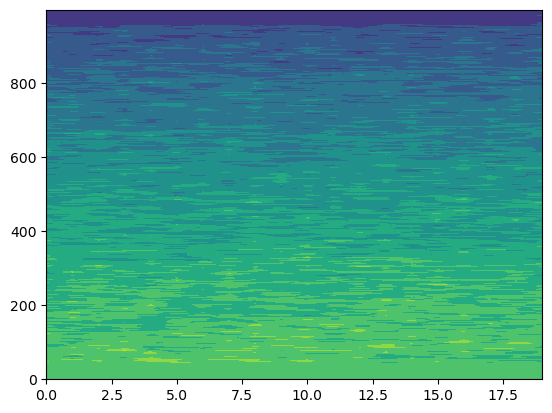

In [597]:
plt.contourf(B[2])

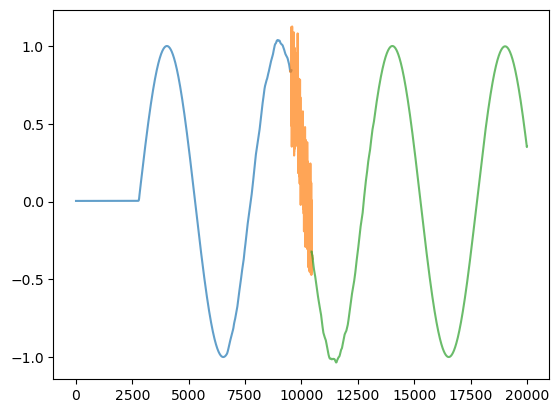

In [598]:
plt.plot(y_coordinate_mhd, Bz_lower_mhd[:, 10], alpha=0.7)
plt.plot(y_coordinate_pic + 9500, B[2, :, 10], alpha=0.7)
plt.plot(y_coordinate_mhd + 10450, Bz_upper_mhd[:, 10], alpha=0.7)
#plt.xlim(8000, 12000)

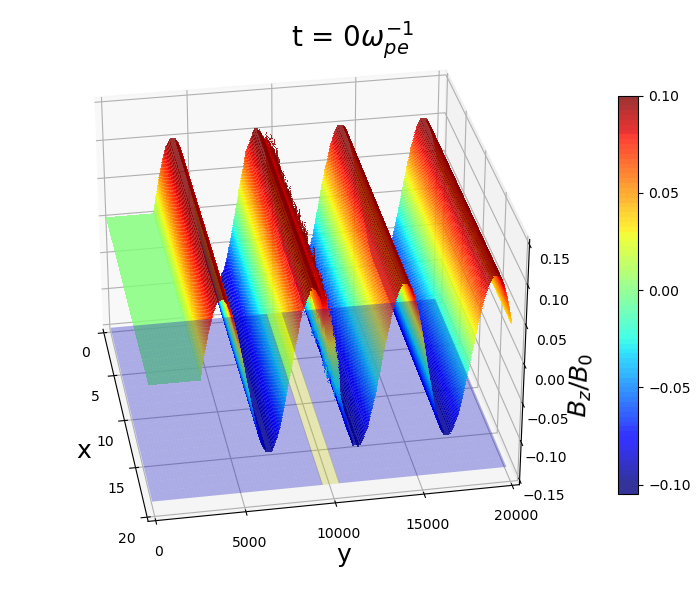

In [600]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

xmin = 0
xmax = 20
mappable = ax.contourf(X_mhd[:, xmin:xmax], Y_mhd[:, xmin:xmax],         Bz_lower_mhd[:, xmin:xmax] / B0_mhd, vmin=-0.10, vmax=0.10, levels=100, alpha=0.8, cmap='jet')
mappable = ax.contourf(X_pic[:, xmin:xmax], Y_pic[:, xmin:xmax] + 9500,  B[2, :, xmin:xmax] / B0_pic,         vmin=-0.10, vmax=0.10, levels=100, alpha=0.8, cmap='jet')
mappable = ax.contourf(X_mhd[:, xmin:xmax], Y_mhd[:, xmin:xmax] + 10450, Bz_upper_mhd[:, xmin:xmax] / B0_mhd, vmin=-0.10, vmax=0.10, levels=100, alpha=0.8, cmap='jet')
cbar = fig.colorbar(mappable, ax=ax, shrink=0.7)
cbar.set_ticks(np.arange(-0.10, 0.11, 0.05))

ax.plot_surface(X_mhd[:, xmin:xmax], Y_mhd[:, xmin:xmax],         -0.15 * np.ones(X_mhd[:, xmin:xmax].shape), color='blue',   alpha=0.3)
ax.plot_surface(X_pic[:, xmin:xmax], Y_pic[:, xmin:xmax] + 9500,  -0.15 * np.ones(X_pic[:, xmin:xmax].shape), color='yellow', alpha=0.3)
ax.plot_surface(X_mhd[:, xmin:xmax], Y_mhd[:, xmin:xmax] + 10450, -0.15 * np.ones(X_mhd[:, xmin:xmax].shape), color='blue',   alpha=0.3)

ax.set_xlim(0, 20)
ax.set_ylim(0, 20000)
ax.set_zlim(-0.15, 0.15)
ax.set_xticks([0, 5, 10, 15, 20])
ax.set_yticks([0, 5000, 10000, 15000, 20000])
ax.set_zticks([-0.15, -0.10, -0.05, 0.0, 0.05, 0.10, 0.15])

ax.set_xlabel('x',           fontsize=18)
ax.set_ylabel('y',           fontsize=18)
ax.set_zlabel('$B_z / B_0$', fontsize=18, labelpad=5)

ax.set_title(f"t = {0}" + r"$\omega_{pe}^{-1}$", fontsize=20, x = 0.6, y=1.0)
ax.view_init(elev=30, azim=-10)
fig.tight_layout()
plt.savefig('plot.png', bbox_inches='tight')

動画作成

C:\Users\keita\AppData\Local\Temp\ipykernel_14560\806941547.py:59: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


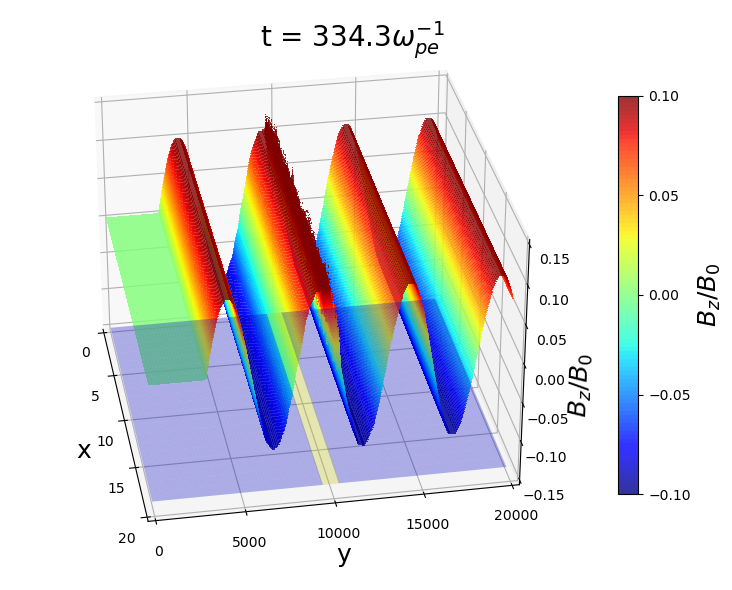

In [605]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

dirname = "results_alfven"
filename_movie = "Alfven_MHD-PIC.mp4"
log = np.loadtxt('log.txt', dtype=str)

interval = 100
plot_steps = 10000
for step in range(0, plot_steps+1, interval):
    ax.clear()

    filename = f"{dirname}/alfven_B_{step}.bin"
    with open(filename, 'rb') as f:
        B = np.fromfile(f, dtype=np.float64)
    B = B.reshape(nx_pic, ny_pic, 3).T

    filename = f"{dirname}/alfven_lower_U_{step}.bin"
    with open(filename, 'rb') as f:
        U_lower = np.fromfile(f, dtype=np.float64)
    U_lower = U_lower.reshape(nx_mhd, ny_mhd, 8).T
    Bz_lower_mhd = U_lower[6, :]

    filename = f"{dirname}/alfven_upper_U_{step}.bin"
    with open(filename, 'rb') as f:
        U_upper = np.fromfile(f, dtype=np.float64)
    U_upper = U_upper.reshape(nx_mhd, ny_mhd, 8).T
    Bz_upper_mhd = U_upper[6, :]


    xmin = 0
    xmax = 20
    mappable = ax.contourf(X_mhd[:, xmin:xmax], Y_mhd[:, xmin:xmax],         Bz_lower_mhd[:, xmin:xmax] / B0_mhd, vmin=-0.10, vmax=0.10, levels=100, alpha=0.8, cmap='jet')
    mappable = ax.contourf(X_pic[:, xmin:xmax], Y_pic[:, xmin:xmax] + 9500,  B[2, :, xmin:xmax] / B0_pic,         vmin=-0.10, vmax=0.10, levels=100, alpha=0.8, cmap='jet')
    mappable = ax.contourf(X_mhd[:, xmin:xmax], Y_mhd[:, xmin:xmax] + 10450, Bz_upper_mhd[:, xmin:xmax] / B0_mhd, vmin=-0.10, vmax=0.10, levels=100, alpha=0.8, cmap='jet')
    if step == 0:
        cbar = fig.colorbar(mappable, ax=ax, shrink=0.7)
        cbar.set_ticks(np.arange(-0.10, 0.11, 0.05))
        cbar.set_label('$B_z / B_0$', fontsize=18)

    ax.plot_surface(X_mhd[:, xmin:xmax], Y_mhd[:, xmin:xmax],         -0.15 * np.ones(X_mhd[:, xmin:xmax].shape), color='blue',   alpha=0.3)
    ax.plot_surface(X_pic[:, xmin:xmax], Y_pic[:, xmin:xmax] + 9500,  -0.15 * np.ones(X_pic[:, xmin:xmax].shape), color='yellow', alpha=0.3)
    ax.plot_surface(X_mhd[:, xmin:xmax], Y_mhd[:, xmin:xmax] + 10450, -0.15 * np.ones(X_mhd[:, xmin:xmax].shape), color='blue',   alpha=0.3)

    ax.set_xlim(0, 20)
    ax.set_ylim(0, 20000)
    ax.set_zlim(-0.15, 0.15)
    ax.set_xticks([0, 5, 10, 15, 20])
    ax.set_yticks([0, 5000, 10000, 15000, 20000])
    ax.set_zticks([-0.15, -0.10, -0.05, 0.0, 0.05, 0.10, 0.15])

    ax.set_xlabel('x',           fontsize=18)
    ax.set_ylabel('y',           fontsize=18)
    ax.set_zlabel('$B_z / B_0$', fontsize=18, labelpad=5)

    time = float(log[int(step/interval), 7].replace(',', ''))
    ax.set_title(f"t = {time:.1f}" + r"$\omega_{pe}^{-1}$", fontsize=20, x = 0.6, y=1.0)
    ax.view_init(elev=30, azim=-10)
    fig.tight_layout()

    fig.savefig(f'./pictures/{step}.png', dpi=200)


img = cv2.imread(f'./pictures/0.png')
framesize = (img.shape[1], img.shape[0])
fps = 5.0

fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
video  = cv2.VideoWriter(filename=filename_movie, fourcc=fourcc, fps=fps, frameSize=framesize)

for step in range(0, plot_steps+1, interval):
    img = cv2.imread(f'./pictures/{step}.png')
    video.write(img)
video.release()

分散関係

In [58]:
dirname = "results_MS_alfven"
 
Bz_total = np.zeros([400, 20000])
for step in range(0, 2000, 5):
    U1 = np.load(f"{dirname}/U1_{step}.npy")
    U2 = np.load(f"{dirname}/U2_{step}.npy")
    B = np.load(f"{dirname}/B_{step}.npy")

    Bz_total[int(step/5), :nx_mhd-interface_width] = U1[6, :nx_mhd-interface_width]
    Bz_total[int(step/5), nx_mhd-interface_width : nx_mhd-interface_width+nx_pic] = B[2, :]
    Bz_total[int(step/5), -nx_mhd+interface_width:] = U2[6, -nx_mhd+interface_width:]

C:\Users\keita\AppData\Local\Temp\ipykernel_19116\3693781112.py:18: RuntimeWarning: divide by zero encountered in divide
  ax.plot(kx, -omega_ce/2 / (1.0 + omega_pe**2/kx**2/c**2) * ((1.0 + 4.0*omega_pi**2/kx**2/c**2)**0.5 + 1.0), color='white', lw=2, label=r"whistler")
C:\Users\keita\AppData\Local\Temp\ipykernel_19116\3693781112.py:18: RuntimeWarning: invalid value encountered in multiply
  ax.plot(kx, -omega_ce/2 / (1.0 + omega_pe**2/kx**2/c**2) * ((1.0 + 4.0*omega_pi**2/kx**2/c**2)**0.5 + 1.0), color='white', lw=2, label=r"whistler")
C:\Users\keita\AppData\Local\Temp\ipykernel_19116\3693781112.py:19: RuntimeWarning: divide by zero encountered in divide
  ax.plot(kx, -omega_ce/2 / (1.0 + omega_pe**2/kx**2/c**2) * ((1.0 + 4.0*omega_pi**2/kx**2/c**2)**0.5 - 1.0), color='black', lw=2, label=r"ion cyclotron")
C:\Users\keita\AppData\Local\Temp\ipykernel_19116\3693781112.py:19: RuntimeWarning: invalid value encountered in multiply
  ax.plot(kx, -omega_ce/2 / (1.0 + omega_pe**2/kx**2/c**2) 

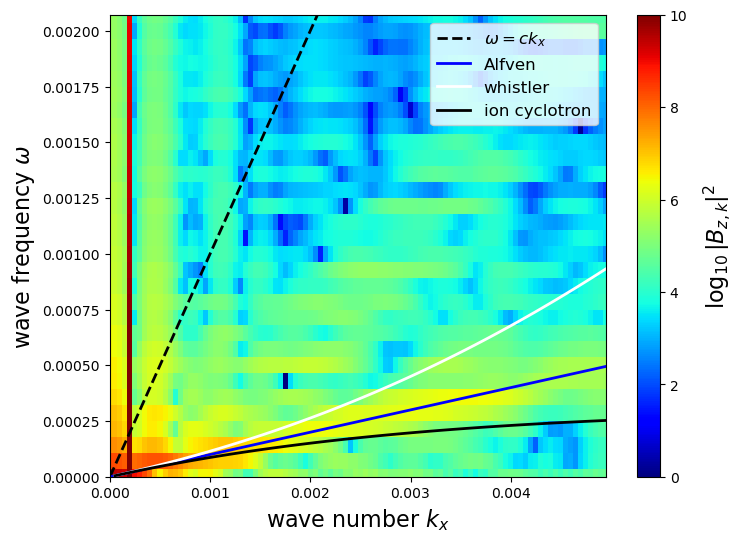

In [72]:
Bz_FFT = np.fft.fft2(Bz_total)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

dt_tmp = 35.0
kx = np.fft.fftfreq(20000, d=dx_mhd)[:100]
omega = np.fft.fftfreq(400, d=dt_tmp)[:30]
X, Y = np.meshgrid(kx, omega)

contour = ax.pcolormesh(X, Y, np.log10(np.abs(Bz_FFT[:30, :100])**2), vmin=0, vmax=10.0, cmap='jet')
cbar = plt.colorbar(contour, ax=ax)
cbar.set_label(r"$\log_{10} |B_{z, k}|^2$", fontsize=16, labelpad=10)

ax.plot(kx, c * kx, lw=2, color='black', ls='dashed', label=r"$\omega = c k_x$")
#ax.vlines(kx[5], 0, 100, color='purple', lw=2, label=r"mode 5")
ax.plot(kx, VA_pic * kx, color='blue', lw=2, label=r"Alfven")
ax.plot(kx, -omega_ce/2 / (1.0 + omega_pe**2/kx**2/c**2) * ((1.0 + 4.0*omega_pi**2/kx**2/c**2)**0.5 + 1.0), color='white', lw=2, label=r"whistler")
ax.plot(kx, -omega_ce/2 / (1.0 + omega_pe**2/kx**2/c**2) * ((1.0 + 4.0*omega_pi**2/kx**2/c**2)**0.5 - 1.0), color='black', lw=2, label=r"ion cyclotron")
ax.set_xlabel(r"wave number $k_x$", fontsize=16)
ax.set_ylabel(r"wave frequency $\omega$", fontsize=16)
ax.set_xlim(0, kx[-1])
ax.set_ylim(0, omega[-1])
ax.legend(loc='upper right', fontsize=12)

fig.savefig("dispersion1.png", dpi=200)